In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit
from astropy.io import fits
import corner
from IPython.display import Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'Blues'


def set_iniVals(X0,X0_lim,Y0,Y0_lim,PA,PA_lim,ell,ell_lim,I0,I_lim,sigma,sigma_lim):
    model_desc = pyimfit.SimpleModelDescription()
    # define the X0,Y0 initial guess and limits
    model_desc.x0.setValue(X0, X0_lim)
    model_desc.y0.setValue(Y0, Y0_lim)
    # create a Gaussian image function for the star and set its parameters' initial guesses and limits
    star_function = pyimfit.make_imfit_function("Gaussian")
    ## position angle
    star_function.PA.setValue(PA,PA_lim)
    star_function.ell.setValue(ell, ell_lim)
    star_function.I_0.setValue(I0, I_lim)
    star_function.sigma.setValue(sigma, sigma_lim)
    # now add the image function to the model
    model_desc.addFunction(star_function)
    return model_desc



def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood


def lnPrior_limits( params, imfitter ):
    parameterLimits = imfitter.getParameterLimits()
    if None in parameterLimits:
        raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        ## if param value is outside of the limits set by the model
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0

def PlotAllWalkers(sample_chain, yAxisLabel):
    fig,ax = plt.subplots(ndims,1,figsize=(5,20))
    nWalkers = sample_chain.shape[0]
    for j in range(6):
        for i in range(nWalkers):
            ax[j].plot(sample_chain[i,:,j], color='0.5')
    [ax[i].set_xlabel('Step number') for i in range(6)]
    [ax[i].set_ylabel(yAxisLabel[i]) for i in range(6)];

In [2]:
#fits.open("test.fits")[0].header

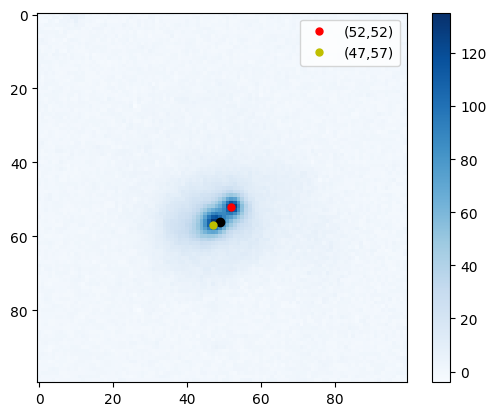

In [3]:
imageFile = "test.fits"
imageAGN = fits.getdata(imageFile)
plt.imshow(imageAGN)
plt.plot(49,56,"ko")
plt.plot(52,52,"ro",markersize=5,label="(52,52)")
plt.plot(47,57,"yo",markersize=5,label="(47,57)")
plt.colorbar()
plt.legend();

X0 = 50
X0_lim = [0,100]
Y0 = 50
Y0_lim = [0,100]
PA = 45
PA_lim = [0,90]
ell = 0.5
ell_lim = [0,1]
I0 = 100
I_lim = [0,150]
sigma = 10
sigma_lim = [0,15]

model_desc = set_iniVals(X0,X0_lim,Y0,Y0_lim,PA,PA_lim,ell,ell_lim,I0,I_lim,sigma,sigma_lim)
print(model_desc)

imfit_fitter = pyimfit.Imfit(model_desc)
imfit_fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=15.683)


results = imfit_fitter.doFit()
p_bestfit = results.params



labels = ["$X_{0}$", "$Y_{0}$", "PA", "$\epsilon$", "$I_{0}$", "$\sigma$"] 
print("Best-fitting parameter values:")
for i in range(len(p_bestfit)):
    display(Latex(f"{labels[i]} = {p_bestfit[i]:.3f}"))

In [4]:
X0 = 49
Y0 = 57
X_lim = [0,100]
Y_lim = [0,100]
PA0 = 200
PA_lim = [0,360]
ell0 = 0.1
ell_lim = [0,1]
I0 = 140
I_lim = [0,190]
sigma0 = 3
sigma_lim = [0,10]

Xss = 48
Yss = 55
PA_ss = 240
ell_ss = 0.5
n_ss = 2
I_ss = 1
r_ss = 10


n =10
nss = 20

#def galaxy_model(X0, Y0, PA0, ell0, I0, sigma0, X1, Y1, PA1, ell1, I1, sigma1):
gaus0 = {'PA': [PA0, PA_lim[0],PA_lim[1]], 'ell': [ell0, ell_lim[0],ell_lim[1]], 
'I_0': [I0, I_lim[0],I_lim[1]], 'sigma': [sigma0, sigma_lim[0],sigma_lim[1]]}
gaus0_dict = {'name': "Gaussian", 'label': "gaus0", 'parameters': gaus0}


sersic = {'PA': [PA_ss, 0, 360], 'ell_bulge': [ell_ss, 0, 1], 'n': [n_ss, 0.5, 10],
'I_e': [I_ss, 0.0, 100], 'r_e': [r_ss, 0.0, 10*r_ss]}
sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}


funcset_dict_gaus0 = {'X0': [X0,X0-n,X0+n], 'Y0': [Y0, Y0-2,Y0+2], 
                'function_list': [gaus0_dict,sersic_dict]}


model_dict = {'function_sets': [funcset_dict_gaus0]}
#model_dict = {'function_sets': [funcset_dict_sersic]}
model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)
#return model

print(model)

# FITTING
imfit_fitter = pyimfit.Imfit(model)


#"""
imfit_fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
results = imfit_fitter.doFit()
p_bestfit = results.params
p_bestfit 

labels = ["$X_{0}$", "$Y_{0}$", "$PA_0$", "$\epsilon_0$", "$I_{0}$", "$\sigma_0$",
          "$PA_{ss0}$", "$\epsilon_{ss0}$", "$n_{ss0}$", "$I_{ss0}$", "$r_e0$"] 
print("Best-fitting parameter values:")
for i in range(len(p_bestfit)):
    display(Latex(f"{labels[i]} = {p_bestfit[i]:.3f}"))
#"""

X0		49.0		39.0,59.0
Y0		57.0		55.0,59.0
FUNCTION Gaussian   # LABEL gaus0
PA		200.0		0.0,360.0
ell		0.1		0.0,1.0
I_0		140.0		0.0,190.0
sigma		3.0		0.0,10.0

FUNCTION Sersic   # LABEL bulge
PA		240.0		0.0,360.0
ell_bulge		0.5		0.0,1.0
n		2.0		0.5,10.0
I_e		1.0		0.0,100.0
r_e		10.0		0.0,100.0

Best-fitting parameter values:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

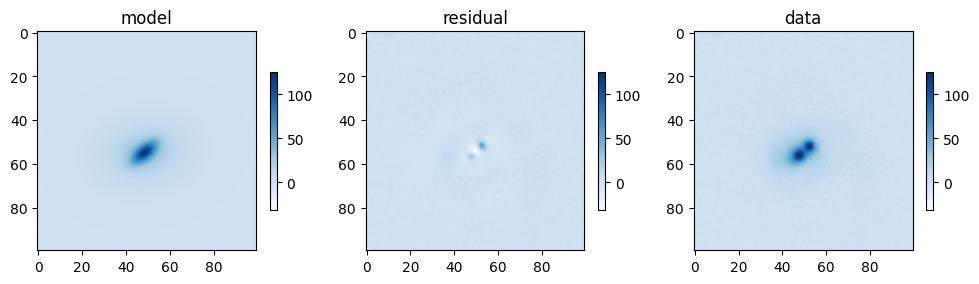

In [16]:
fig, ax = plt.subplots(1, 3,figsize=(12,3))
bestfit_model_im = imfit_fitter.getModelImage()
im0 = ax[0].imshow(bestfit_model_im)
ax[0].set_title("model")

residual = imageAGN - bestfit_model_im
im1 = ax[1].imshow(residual)
ax[1].set_title("residual")

im2 = ax[2].imshow(imageAGN)
ax[2].set_title("data")

# Create a colorbar for each axis
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=0.6)
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.6)
cbar2 = fig.colorbar(im2, ax=ax[2], shrink=0.6)

# Set the same colorbar scale for both axes
vmin = min(im0.get_array().min(), im1.get_array().min())
vmax = max(im0.get_array().max(), im1.get_array().max())
im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)

plt.show()


Number of samples in "converged" chain = 30000


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

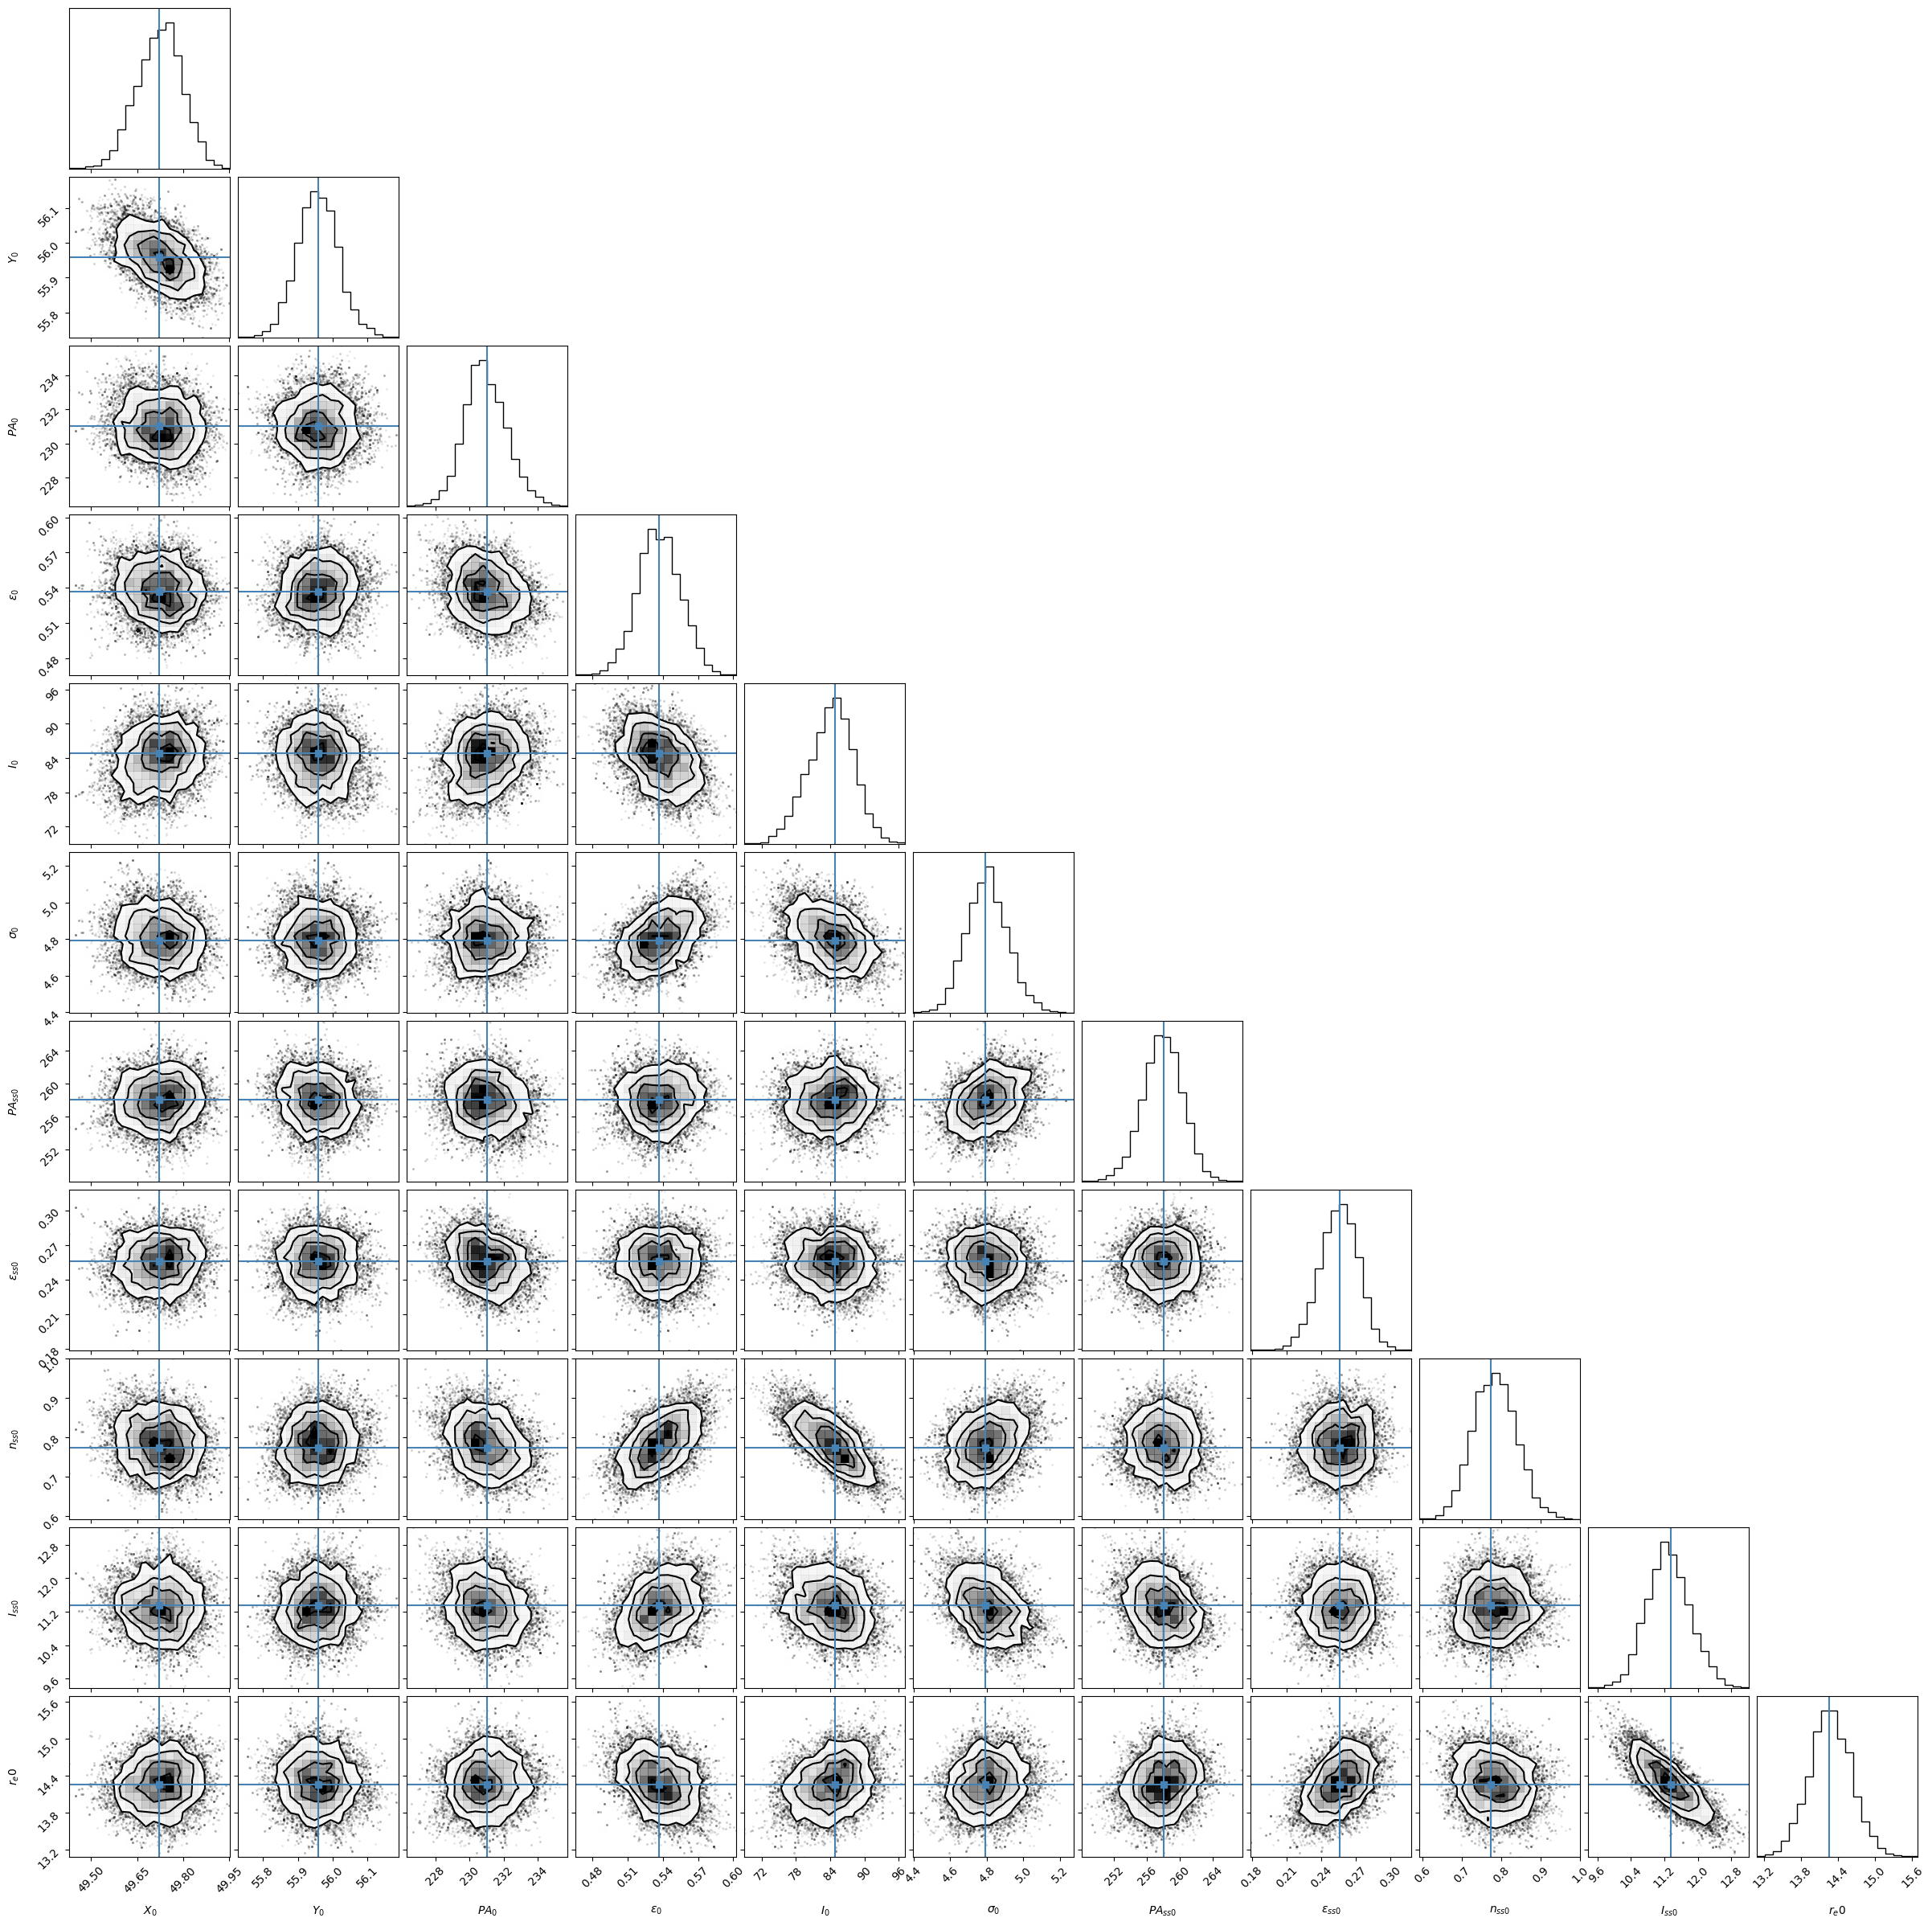

In [6]:
ndims, nwalkers = len(p_bestfit), 100
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))

#inital position around best fit
initial_pos = [p_bestfit * (1 + 0.001*np.random.randn(ndims)) for i in range(nwalkers)]
sampler.reset()
final_state = sampler.run_mcmc(initial_pos, 500)

#plotting samples
converged_samples = sampler.chain[:, 200:, :].reshape((-1, ndims))
print("Number of samples in \"converged\" chain = {0}".format(len(converged_samples)))
fig = corner.corner(converged_samples, labels=labels, truths=p_bestfit)

for i in range(ndims):
    mcmc = np.percentile(converged_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = f'{labels[i]} = {mcmc[1]:.3f} $^{{{q[0]:.3f}}}_{{{q[1]:.3f}}}$'
    display(Latex(txt))